In [14]:
using Distributions
using StatsBase
using PythonPlot
using DataFrames
using Optim
using NLsolve
using Setfield
using CSV
using Turing
using LinearAlgebra
using ParameterHandling
include("simulations.jl")
include("estimators.jl")
include("models.jl")
include("rem_theory.jl")

FIG_PATH = "/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/Finite Lineages Plos Journal/paper/figures"

"/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/Finite Lineages Plos Journal/paper/figures"

# setup

## Load data

In [20]:
# Read CSV file
#data = CSV.read("/Users/elevien/Downloads/experimental_data/cell_list_25C.csv", DataFrame)
data = CSV.read("./output/data/25C_celllist.csv",DataFrame)

L = length(data[data.lineage .== 2,:lineage])
M = length(unique(data.lineage))
data[:,:n] = vcat([collect(1:L) for i in 1:M]...) .-1
data[:,:t] = vcat([(cumsum(data[data.lineage .== l,:gt]) .-data[data.lineage .== l,:gt][1])  for l in unique(data.lineage)]...)

# gt = []
# for i in unique(data.lineage)
#     gti = diff(data[data.lineage .== i,:t])
#     push!(gt,vcat(gti,gti[end]))
# end
# gt = vcat(gt...)
# data[:,:gt] = gt;
# μ = mean(data[:,:gt])
# data[:,:gt] = data[:,:gt]
data[:,:y] = log.(data[:,:s0])
data[:,:gr] = log.(data[:,:sf]./data[:,:s0]) ./ data[:,:gt];

## Fitting functions

Note: Move to .jl file

# Fitting

## Fit autoregressive mode

In [21]:

y = Matrix(data[data.lineage .== 5,[:gt]]);
L = length(y[:,1])
M = 70
fits = [value_flatten(fitar(Matrix(data[data.lineage .== l,[:gt]]))) for l in unique(data.lineage)]
θar1=  fits[1][2](median(hcat([f[1] for f in fits]...),dims=2)[:,1])
times = runar(y[1,:],θar1,L*M);
n = vcat([collect(1:L) for k in 1:M]...) .- 1;
lineages = vcat([ones(L)*k for k in 1:M]...);
ar1 = DataFrame((lineage=lineages,gt = times[:,1],t=cumsum( times[:,1]),n=n));
ar1.t = vcat([ar1[ar1.lineage .==l,:t] .- ar1[ar1.lineage .==l,:t][1] for l in unique(ar1.lineage)]...);


ar1
CSV.write("./output/ar1_fitted.csv",ar1)
CSV.write("./output/ar1_fitted_params",[θar1])
θ_fit
mean(y)


UndefVarError: UndefVarError: `θ_fit` not defined

## Fit CellSize control model

In [22]:

y = Matrix(data[data.lineage .== 5,[:y,:gt]]);
L = length(y[:,1])
M = 70
fits = [value_flatten(fitar(Matrix(data[data.lineage .== l,[:y,:gt]]))) for l in unique(data.lineage)]
θcsc =  fits[1][2](median(hcat([f[1] for f in fits]...),dims=2)[:,1])
out = runar(y[1,:],θcsc,L*M);
n = vcat([collect(1:L) for k in 1:M]...) .- 1;
lineages = vcat([ones(L)*k for k in 1:M]...);
csc = DataFrame((lineage=lineages,gt = out[:,2],y =out[:,1],n=n));
csc[:,:t] = vcat([(cumsum(csc[csc.lineage .== l,:gt]) .-csc[csc.lineage .== l,:gt][1])  for l in unique(csc.lineage)]...);
CSV.write("./output/csc_fitted.csv",csc)
CSV.write("./output/csc_fitted_params",[θcsc])

"./output/csc_fitted_params"

## Fit cell-size control model (WIP)

# Plot Trajectories

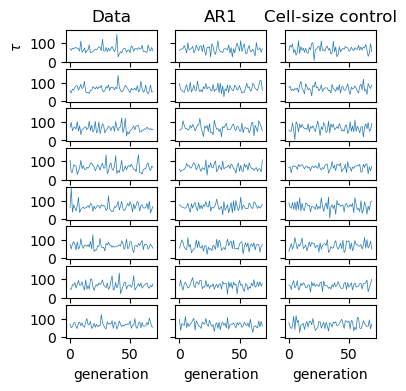

In [23]:
nrows = 8
fig, axs= subplots(figsize=(4,4),ncols = 3,nrows=nrows,sharex=true,sharey=true)

for l in  1:nrows


    ax = axs[l-1,0]
    ax.plot(data[data.lineage .== l,:gt],"-",lw=0.5)

    ax = axs[l-1,1]
    ax.plot(ar1[ar1.lineage .== l,:gt],"-",lw=0.5)

    ax = axs[l-1,2]
    ax.plot(csc[csc.lineage .== l,:gt],"-",lw=0.5)

end
axs[0,0].set_title("Data")
axs[0,0].set_ylabel(L"$\tau$")
axs[-1,0].set_xlabel("generation")
axs[-1,1].set_xlabel("generation")
axs[-1,2].set_xlabel("generation")
axs[0,1].set_title("AR1")
axs[0,2].set_title("Cell-size control")
fig

# Plot estimate vs. alpha

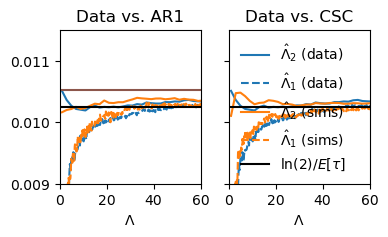

In [26]:
fig, axs= subplots(figsize=(4,2),ncols=2,sharey=true,sharex=true)
n_range = 1:2:65
t_range =  sort(unique(data.t))[1:10:end]

# data -----------------------------------------------------------------
for ax in axs
    ax.plot(n_range,[FDE(data[data.n .== k,:t],k) for k in n_range],"C0-",label=L"$\hat{\Lambda}_2$ (data)")

    N = [[length(data[(data.lineage .== l) .& (data.t .<= t),:n])-1 for l in unique(data.lineage)] for t in t_range]
    ax.plot(t_range ./ mean(data.gt),[FTE(N[i],t_range[i]) for i in 1:length(t_range)],"C0--",label=L"$\hat{\Lambda}_1$ (data)")
end 
# ar1 -----------------------------------------------------------------
t_range =  sort(unique(ar1.t))[1:10:end]
axs[0].set_title("Data vs. AR1")
axs[0].plot(n_range,[FDE(ar1[ar1.n .== k,:t],k) for k in n_range],"C1-",label=L"$\hat{\Lambda}_2$ (AR1)")

N = [[length(ar1[(ar1.lineage .== l) .& (ar1.t .<= t),:n])-1 for l in unique(ar1.lineage)] for t in t_range]
axs[0].plot(t_range ./ mean(data.gt),[FTE(N[i],t_range[i]) for i in 1:length(t_range)],"C1--",label=L"$\hat{\Lambda}_1$ (AR1)")


# csc -----------------------------------------------------------------
t_range =  sort(unique(csc.t))[1:10:end]
axs[1].set_title("Data vs. CSC")
axs[1].plot(n_range,[FDE(csc[csc.n .== k,:t],k) for k in n_range],"C1-",label=L"$\hat{\Lambda}_2$ (sims)")

N = [[length(csc[(csc.lineage .== l) .& (csc.t .<= t),:n])-1 for l in unique(ar1.lineage)] for t in t_range]
axs[1].plot(t_range ./ mean(data.gt),[FTE(N[i],t_range[i]) for i in 1:length(t_range)],"C1--",label=L"$\hat{\Lambda}_1$ (sims)")

# annotations ----------------------------------------------------------
for ax in axs
    ax.plot(t_range ./ mean(data.gt), log(2)*ones(length(t_range)) ./ mean(data.gt) ,"k-",label=L"$\ln(2)/E[\tau]$")
    ax.set_ylim([0.009,0.0115])
    ax.set_xlim([0,60])
    ax.set_xlabel(L"$t/\tau_0$")
    ax.set_xlabel(L"$\Lambda$")
    
end
Ltrue = 2log(2)/(1+sqrt(1-2log(2)*(θar1.v[1]/mean(data.gt)^2/(1-θar1.b[2,1]^2))))/mean(data.gt) 
axs[0].plot(t_range ./ mean(data.gt),Ltrue*ones(length(t_range)),"C5")
axs[1].legend(frameon=false)
savefig(FIG_PATH*"/data_vs_ar1_convergence.pdf",bbox_inches="tight")
fig

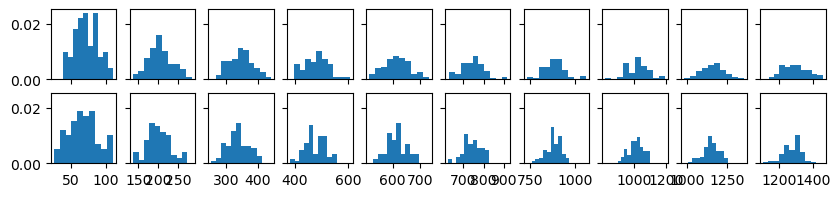

In [9]:
inds = collect(1:1:10)
fig,axs = subplots(figsize=(10,2),ncols = length(inds),nrows=2,sharex="col",sharey=true)
[axs[0,k-1].hist(ar1[ar1.n .== n_range[k],:t],10,density=true) for k in eachindex(n_range[inds])]
[axs[1,k-1].hist(csc[csc.n .== n_range[k],:t],10,density=true) for k in eachindex(n_range[inds])]
fig

# Check scaling of variance

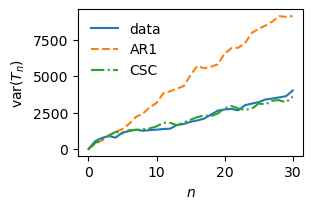

In [11]:
fig,ax = subplots(figsize=(3,2))
ax.plot(combine(groupby(grouplineages(data,30),:n),:t => var => :v).v,"-",label="data")
ax.plot(combine(groupby(grouplineages(ar1,30),:n),:t => var => :v).v,"--",label="AR1")
ax.plot(combine(groupby(grouplineages(csc,30),:n),:t => var => :v).v,"-.",fillstyle="none",label="CSC")
tight_layout()
ax.set_xlabel(L"$n$")
ax.set_ylabel(L"${\rm var}(T_n)$")
ax.legend(frameon=false)
fig
